# Nepali Handwritten Digits Classification

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from displayData import displayData

In [19]:
data = np.genfromtxt('Train.csv', delimiter=',', dtype=None)

In [20]:
np.random.shuffle(data) # shuffle ordered data

In [21]:
data.shape

(17000, 1025)

In [22]:
#separate label and features
X_train= data[:,:1024]/255
y_train = data[:,1024] 

In [23]:
data_val = np.genfromtxt('Test.csv', delimiter=',', dtype=None)
np.random.shuffle(data_val) # shuffle ordered data
#separate label and features
X_val= data_val[:,:1024]/255
y_val = data_val[:,1024]
y_val = np.eye(10)[y_val]

In [24]:
a = X_val[58].reshape((32,32))

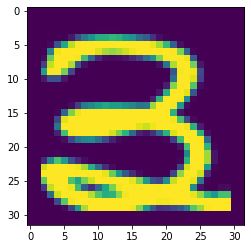

In [25]:
plt.imshow(a)

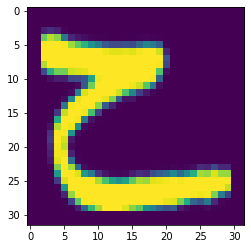

In [26]:
plt.imshow(X_train[9].reshape((32,32)))

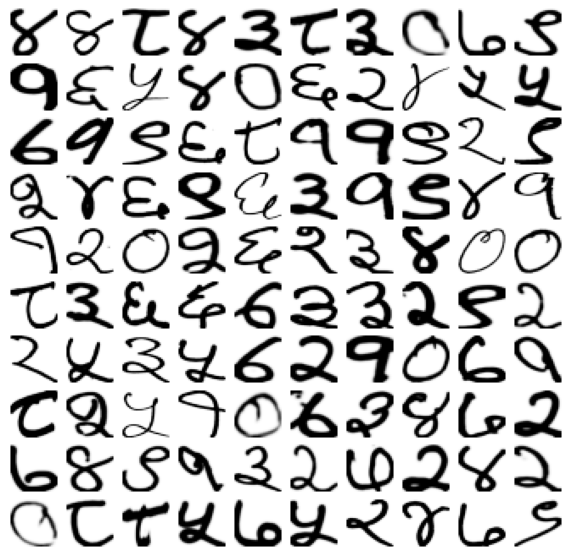

In [27]:
rand_indices = np.random.choice(y_train.shape[0], 100, replace=False)
sel = X_train[rand_indices, :]
displayData(sel)

# 3 Layered Neural Network Algorithm From Scratch

In [28]:
class NeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001,lambda_=0):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.lambda_=lambda_
        self.costs=[]
        self.epsilon_init=0.12
        
        # we save all parameters in the neural network in this dictionary
        #self.params = {
         #   'Theta1': np.random.rand(self.sizes[1], self.sizes[0]+1) * 2 * self.epsilon_init - self.epsilon_init,
          #  'Theta2':np.random.randn(self.sizes[2], self.sizes[1]+1) * 2 * self.epsilon_init - self.epsilon_init
        #}
        self.params = self.initialization()
    
    def sigmoid(self, z, derivative=False):
        if derivative:
            return (np.exp(-z))/((np.exp(-z)+1)**2) #sigmoid gradient
        return 1/(1 + np.exp(-z))
    
    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden=self.sizes[1]
        output_layer=self.sizes[2]

        params = {
            'Theta1': np.random.rand(hidden, input_layer+1) * 2 * self.epsilon_init - self.epsilon_init,
            'Theta2':np.random.randn(output_layer, hidden+1) * 2 * self.epsilon_init - self.epsilon_init
        }
        return params
        
    
    
    def forward_pass(self, x_train):
        '''Calculate op using forward propagation'''
        params = self.params
        m = x_train.shape[0]
        # input layer activations becomes sample
        params['A1'] = np.concatenate([np.ones((1)), x_train])

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["Theta1"], params['A1'])
        params['A2'] = np.concatenate([np.ones(1), self.sigmoid(params['Z1'])])

        # hidden layer to op layer
        params['Z2'] = np.dot(params["Theta2"], params['A2'])
        params['A3'] = self.sigmoid(params['Z2'])

        return params['A3']
        
    def backward_pass(self, y_train, output):
        '''Backpropagation algorith to calculate errors'''
        params = self.params
        change_w = {}
        #m=y_train.size
        #print('M= ',m)
        # Calculate W2 update
        error = params['A3']-y_train
        change_w['Theta2'] = np.outer(error, self.params['A2'])
        #print(Del2.shape)
        change_w['Theta2'][:,1:] =  change_w['Theta2'][:,1:] + (self.lambda_) * self.params['Theta2'][:, 1:]

        # Calculate W1 update
        error = np.dot(params['Theta2'][:, 1:].T, error) * self.sigmoid(self.params['Z1'], derivative=True)
        change_w['Theta1'] = np.outer(error, params['A1'])
        change_w['Theta1'][:,1:] = change_w['Theta1'][:,1:] + (self.lambda_) * self.params['Theta1'][:, 1:]

        return change_w
        
    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                        i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            #print(self.params[key].shape)
            #print(value.shape)
            self.params[key] -= self.l_rate * value

    def compute_cost(self,y,op):
        J = -(np.sum(y * np.log(op) + (1-y) * np.log(1-op))) #cost without regularization terms
        reg = (self.lambda_/2) * (np.sum(np.square(self.params['Theta1'][:, 1:])) + np.sum(np.square(self.params['Theta2'][:, 1:])))
        return J+reg
                
    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)
    def plot_costs(self):
        plt.plot(self.costs)
        plt.xlabel('No. of iterations')
        plt.ylabel('Average Cost')
        plt.title('Cost vs gradient descent iteration')
    def predict(self,x):
        '''predict the output for given inputs using trained parameters'''
        return self.forward_pass(x).argmax()
        
    def train(self, x_train, y_train, x_val, y_val):
        y_train = np.eye(10)[y_train]
        for iteration in range(self.epochs):
            cost=0
            for x,y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)
                cost+=self.compute_cost(y,output)
            #print(cost)
            self.costs.append(cost/y_train.size)
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch:',iteration+1,", Accuracy: ",accuracy*100)

In [29]:
dnn = NeuralNetwork(sizes=[1024, 25, 10],epochs=30,lambda_=0)

In [30]:
dnn.train(X_train, y_train, X_val, y_val)

Epoch: 1 , Accuracy:  83.16666666666667
Epoch: 2 , Accuracy:  86.9
Epoch: 3 , Accuracy:  88.73333333333333
Epoch: 4 , Accuracy:  89.96666666666667
Epoch: 5 , Accuracy:  91.2
Epoch: 6 , Accuracy:  91.7
Epoch: 7 , Accuracy:  92.2
Epoch: 8 , Accuracy:  92.86666666666666
Epoch: 9 , Accuracy:  93.56666666666666
Epoch: 10 , Accuracy:  93.83333333333333
Epoch: 11 , Accuracy:  94.13333333333334
Epoch: 12 , Accuracy:  94.36666666666666
Epoch: 13 , Accuracy:  94.53333333333333
Epoch: 14 , Accuracy:  94.76666666666667
Epoch: 15 , Accuracy:  94.96666666666667
Epoch: 16 , Accuracy:  95.06666666666666
Epoch: 17 , Accuracy:  95.13333333333334
Epoch: 18 , Accuracy:  95.36666666666666
Epoch: 19 , Accuracy:  95.43333333333334
Epoch: 20 , Accuracy:  95.5
Epoch: 21 , Accuracy:  95.56666666666666
Epoch: 22 , Accuracy:  95.6
Epoch: 23 , Accuracy:  95.63333333333334
Epoch: 24 , Accuracy:  95.73333333333333
Epoch: 25 , Accuracy:  95.73333333333333
Epoch: 26 , Accuracy:  95.8
Epoch: 27 , Accuracy:  95.93333333

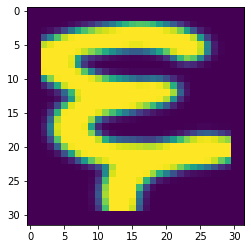

In [13]:
plt.imshow(X_val[0].reshape((32,32)))

In [35]:
np.save('Theta1.npy',dnn.params['Theta1'])

In [32]:
!ls

 api.py		  image.png			    README.md   Test.csv
 dataset	  img2Array.py			    samp2.npy   Theta1.npy
 displayData.py  'Nepali Digit Recognition.ipynb'   samp.npy    Theta2.npy
 helper.py	  __pycache__			    static      Train.csv


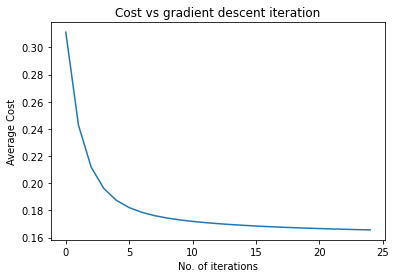

In [158]:
dnn.plot_costs()

In [14]:
d = np.load('samp2.npy')
c = d.reshape((32,32))

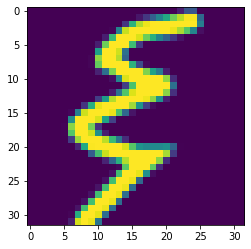

In [15]:
plt.imshow(c)

In [16]:
dnn.predict(d)

3

In [17]:
test = np.random.choice(3000,3,replace=False)
for i in test:
    output=dnn.predict(X_val[i])
    print('Obtained: ',output, ", Expected: ",y_val[i].argmax())

Obtained:  4 , Expected:  4
Obtained:  0 , Expected:  0
Obtained:  1 , Expected:  5


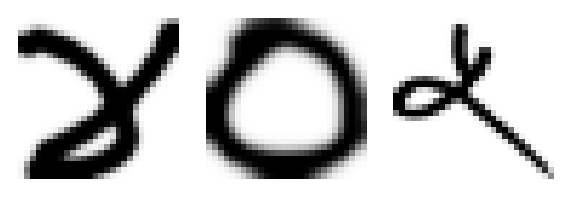

In [18]:
displayData(X_val[test, :])

## One vs All Logistic Regression

In [31]:
class LogisticRegression:
    def __init__(self, epochs=10, l_rate=0.001,lambda_=0):
        self.epochs = epochs
        self.lr = l_rate
        self.lambda_=lambda_
        self.costs=[]
    
    def sigmoid(self,z):
        return 1/(1 + np.exp(-z))
    def cost(self, y, y_hat):                 
        return np.mean(-y*np.log(y_hat)-(1-y)*np.log(1-y_hat))
    def fit(self, x, y):
        #x = self.add_intercept(x)
        m = x.shape[0]
        x = np.concatenate([np.ones((m, 1)), x], axis=1)
        weights = np.zeros(x.shape[1])
        for _ in range(self.epochs):
            y_hat = self.sigmoid(x.dot(weights))
            weights -= self.lr * (1/m)*np.dot(x.T,  y_hat - y)
            self.costs.append(self.cost(y, y_hat))
        self.weights = weights
    def predict(self, x,prob=False):
        x=np.array(x) #because list desn't have shape method
        # Predicting with sigmoid function
        x=self.add_intercept(x)
        z = dot(x, self.weights)
        res = self.sigmoid(z)
        if prob: # return probablity
            return res
        # Returning binary result
        return [1 if i > 0.5 else 0 for i in res]
            

In [32]:
y_train.shape

(17000,)

In [38]:
for c in range(10):
    label = (y_train==c).astype(int)
    print(label)
    log_reg = LogisticRegression()
    log_reg.fit(X_train,label)
    
    

[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 1 ... 1 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


In [135]:
(y_train==1).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
log_reg.weights

array([-0.00364644,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ])

# MNIST

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

In [12]:
mnist = load_digits()
X=mnist.data
y=mnist.target
#y = np.eye(10)[y] #encode output layer with 1 and 0
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

m = y.size

In [15]:
dnn = NeuralNetwork(sizes=[64, 15, 10],epochs=30,lambda_=0.01)

In [16]:
dnn.train(x_train, y_train, x_val, y_val)

Epoch: 1 , Accuracy:  8.518518518518519
Epoch: 2 , Accuracy:  11.11111111111111
Epoch: 3 , Accuracy:  11.481481481481481
Epoch: 4 , Accuracy:  9.25925925925926
Epoch: 5 , Accuracy:  8.88888888888889
Epoch: 6 , Accuracy:  8.88888888888889
Epoch: 7 , Accuracy:  8.88888888888889
Epoch: 8 , Accuracy:  8.88888888888889
Epoch: 9 , Accuracy:  8.88888888888889
Epoch: 10 , Accuracy:  8.88888888888889
Epoch: 11 , Accuracy:  8.518518518518519
Epoch: 12 , Accuracy:  8.148148148148149
Epoch: 13 , Accuracy:  8.148148148148149
Epoch: 14 , Accuracy:  8.148148148148149
Epoch: 15 , Accuracy:  8.148148148148149
Epoch: 16 , Accuracy:  8.148148148148149
Epoch: 17 , Accuracy:  8.148148148148149
Epoch: 18 , Accuracy:  8.148148148148149
Epoch: 19 , Accuracy:  8.148148148148149
Epoch: 20 , Accuracy:  8.148148148148149
Epoch: 21 , Accuracy:  8.148148148148149
Epoch: 22 , Accuracy:  8.148148148148149
Epoch: 23 , Accuracy:  8.148148148148149
Epoch: 24 , Accuracy:  8.148148148148149
Epoch: 25 , Accuracy:  8.148148

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5,
       7, 7, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 3, 5, 6, 6, 0,
       6, 4, 3, 9, 3, 9, 7, 2, 9, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 8, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 8, 8, 5,
       5, 1, 6, 2, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 9, 7,
       7, 0, 1, 0, 4, 5])